Import Library

In [2]:
# Import Library
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

Unzip File

In [3]:
import os
import zipfile

local_zip = 'D://Sem 7//Pembelajaran Mesin//Praktikum//rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # Membaca local path
zip_ref.extractall('D://Sem 7//Pembelajaran Mesin//Praktikum') # Extract .zip file
zip_ref.close()

Split Directory

In [6]:
# Path ke direktori utama
file_dir = 'D://Sem 7//Pembelajaran Mesin//Praktikum//rps'

train_dir = os.path.join(file_dir, 'train')
validation_dir = os.path.join(file_dir, 'validation')
test_dir = os.path.join(file_dir, 'test')

In [7]:
# Daftar label direktori
import shutil
import random

label_directories = os.listdir(file_dir)

for label_dir in label_directories:
    # Path ke direktori label
    label_path = os.path.join(file_dir, label_dir)

    # Daftar file gambar dalam direktori label
    image_files = os.listdir(label_path)

    # Jumlah file gambar
    num_images = len(image_files)

    # Jumlah file gambar untuk setiap split
    num_train = int(num_images * 0.7)
    num_test = int(num_images * 0.05)
    num_valid = int(num_images * 0.25)

    # Acak urutan file gambar
    random.shuffle(image_files)

    # Pisahkan file gambar ke dalam folder train, test, dan valid
    train_files = image_files[:num_train]
    valid_files = image_files[num_train:num_train + num_valid]
    test_files = image_files[num_train + num_valid:]


    # Path ke direktori train, test, dan valid untuk label tertentu
    train_label_dir = os.path.join(train_dir, label_dir)
    test_label_dir = os.path.join(test_dir, label_dir)
    valid_label_dir = os.path.join(validation_dir, label_dir)

    # Buat direktori baru jika belum ada
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(test_label_dir, exist_ok=True)
    os.makedirs(valid_label_dir, exist_ok=True)

    # Pindahkan file gambar ke direktori train
    for file in train_files:
        src_path = os.path.join(label_path, file)
        dest_path = os.path.join(train_label_dir, file)
        shutil.copy(src_path, dest_path)

    # Pindahkan file gambar ke direktori test
    for file in test_files:
        src_path = os.path.join(label_path, file)
        dest_path = os.path.join(test_label_dir, file)
        shutil.copy(src_path, dest_path)

    # Pindahkan file gambar ke direktori valid
    for file in valid_files:
        src_path = os.path.join(label_path, file)
        dest_path = os.path.join(valid_label_dir, file)
        shutil.copy(src_path, dest_path)

EDA

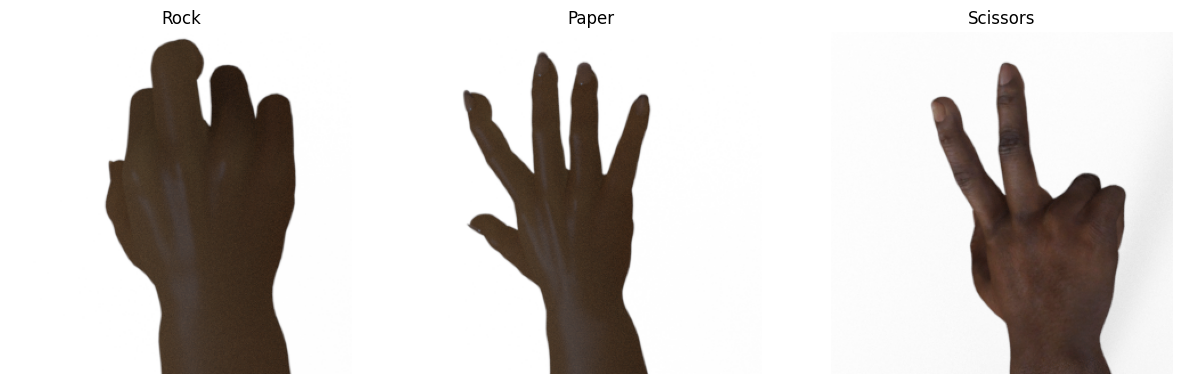

In [8]:
import random
# from PIL import Image
from tensorflow.keras.preprocessing.image import load_img

# Membuat plot dengan dua kolom subplot yang berada dalam satu baris
fig, ax = plt.subplots(1, 3, figsize=(15, 10)) # figsize() untuk set ukurang gambar

sample_rock = random.choice(os.listdir(train_dir+ "/rock")) # library random digunakan untuk memilih data secara acak
image = load_img(train_dir+ "/rock/" + sample_rock) # library load_img digunakan untuk memuat gambar dengan path yang sudah ditentukan
# set gambar untuk kolom pertama (index 0)
ax[0].imshow(image)
ax[0].set_title("Rock")
ax[0].axis("Off")

sample_paper = random.choice(os.listdir(train_dir+ "/paper"))
image = load_img(train_dir+ "/paper/" + sample_paper)
# set gambar untuk kolom kedua (index 1)
ax[1].imshow(image)
ax[1].set_title("Paper")
ax[1].axis("Off")

sample_scissors = random.choice(os.listdir(train_dir+ "/scissors"))
image = load_img(train_dir+ "/scissors/" + sample_scissors)
# set gambar untuk kolom kedua (index 1)
ax[2].imshow(image)
ax[2].set_title("Scissors")
ax[2].axis("Off")

plt.show()

Preparation and Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen     = ImageDataGenerator(
                    rescale=1./255,        # Rescaling image menjadi 1./255
                    rotation_range=30,     # Rotasi image ±30° secara random
                    zoom_range=0.2,        # Perbesar image kisaran 20%
                    horizontal_flip=True,  # Flip image secara horizontal
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [10]:
# implement ImageDataGenerator in train data
train_gen = datagen.flow_from_directory(train_dir, #Direktori data
                                             target_size=(150, 150),
                                             classes=['paper','rock','scissors'],
                                             batch_size=32,
                                             class_mode='categorical') #Menerapkan mode kelas

val_gen = val_datagen.flow_from_directory(validation_dir,
                                      target_size=(150, 150),
                                      classes=['paper','rock','scissors'],
                                      batch_size=32,
                                      class_mode='categorical')

test_gen = datagen.flow_from_directory(
                                      test_dir,
                                      target_size=(150, 150),
                                      classes=['paper','rock','scissors'],
                                      batch_size=32,
                                      class_mode='categorical')

# Menampilkan informasi banyak batch data yang digunakan dalam pelatihan dan training
print('Batches train=%d, validation=%d' % (len(train_gen), len(val_gen)))

Found 1764 images belonging to 3 classes.
Found 630 images belonging to 3 classes.
Found 126 images belonging to 3 classes.
Batches train=56, validation=20


Transfer Learning

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import ResNet101

In [13]:
# Kita load model ResNet101, kemudian kita potong bagian Top atau Fully Connected Layernya
baseModel = ResNet101(
                      weights="imagenet",  # Load weights pre-trained on ImageNet.
                      input_tensor=Input(shape=(150, 150, 3)), # Set Input Model dengan shape yang sesuai dengan ukuran citra
                      include_top=False,
                      )

In [14]:
# Model Summary
baseModel.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [15]:
# Freeze the baseModel karena sudah dilakukan training
baseModel.trainable = False

In [16]:
# Creating Fully Connected
x = baseModel.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(3, activation = 'softmax')(x)
model = Model(inputs = baseModel.input, outputs = outputs)

In [17]:
# Model Summary yang kita buat
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
# Complie Model
from tensorflow.keras.optimizers import Adam

model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
# training Transfer Learning Model ResNet101
history = model.fit(
    train_gen,
    epochs = 10,
    validation_data = val_gen,
)

Epoch 1/10



56/56 [==============================] - 112s 2s/step - loss: 0.6704 - accuracy: 0.5873 - val_loss: 0.3095 - val_accuracy: 0.8476
Epoch 2/10
56/56 [==============================] - 102s 2s/step - loss: 0.3225 - accuracy: 0.8237 - val_loss: 0.2201 - val_accuracy: 0.8651
Epoch 3/10
56/56 [==============================] - 104s 2s/step - loss: 0.2540 - accuracy: 0.8753 - val_loss: 0.1554 - val_accuracy: 0.9397
Epoch 4/10
56/56 [==============================] - 106s 2s/step - loss: 0.2154 - accuracy: 0.8917 - val_loss: 0.1375 - val_accuracy: 0.9270
Epoch 5/10
56/56 [==============================] - 102s 2s/step - loss: 0.1784 - accuracy: 0.9110 - val_loss: 0.1216 - val_accuracy: 0.9524
Epoch 6/10
56/56 [==============================] - 101s 2s/step - loss: 0.1619 - accuracy: 0.9161 - val_loss: 0.0780 - val_accuracy: 0.9857
Epoch 7/10
56/56 [==============================] - 102s 2s/step - loss: 0.1491 - accuracy: 0.9314 - val_loss: 0.0747 - val_accuracy: 0.9730
Epoch 8/10
56/56 [======

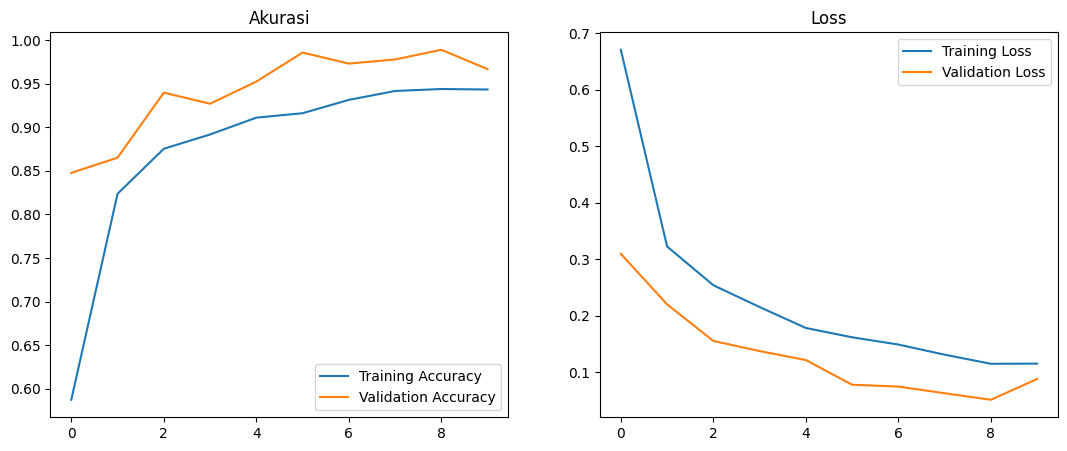

In [20]:
# Visualization Accuracy, Val Accuracy, Loss and Val Loss
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']  
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [21]:
# Printout Accuracy and Loss
loss, accuracy = model.evaluate(val_gen)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

20/20 [==============================] - 25s 1s/step - loss: 0.0882 - accuracy: 0.9667
Validation Loss: 0.08820656687021255
Validation Accuracy: 96.67%


In [22]:
# Showing Classification Report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prediksi menggunakan model
y_pred = model.predict(val_gen)

# Ambil indeks kelas dengan nilai tertinggi sebagai hasil prediksi
y_pred_classes = np.argmax(y_pred, axis=1)

# Label sebenarnya
y_true = val_gen.classes

# Nama kelas
class_labels = list(val_gen.class_indices.keys())

# Tampilkan classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred_classes)
print(report)
print(f"Accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 26s 1s/step
              precision    recall  f1-score   support

       paper       0.31      0.34      0.33       210
        rock       0.31      0.31      0.31       210
    scissors       0.35      0.31      0.33       210

    accuracy                           0.32       630
   macro avg       0.32      0.32      0.32       630
weighted avg       0.32      0.32      0.32       630

Accuracy: 32.22%


In [23]:
model.save('model_predictv4.h5')

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 151ms/step


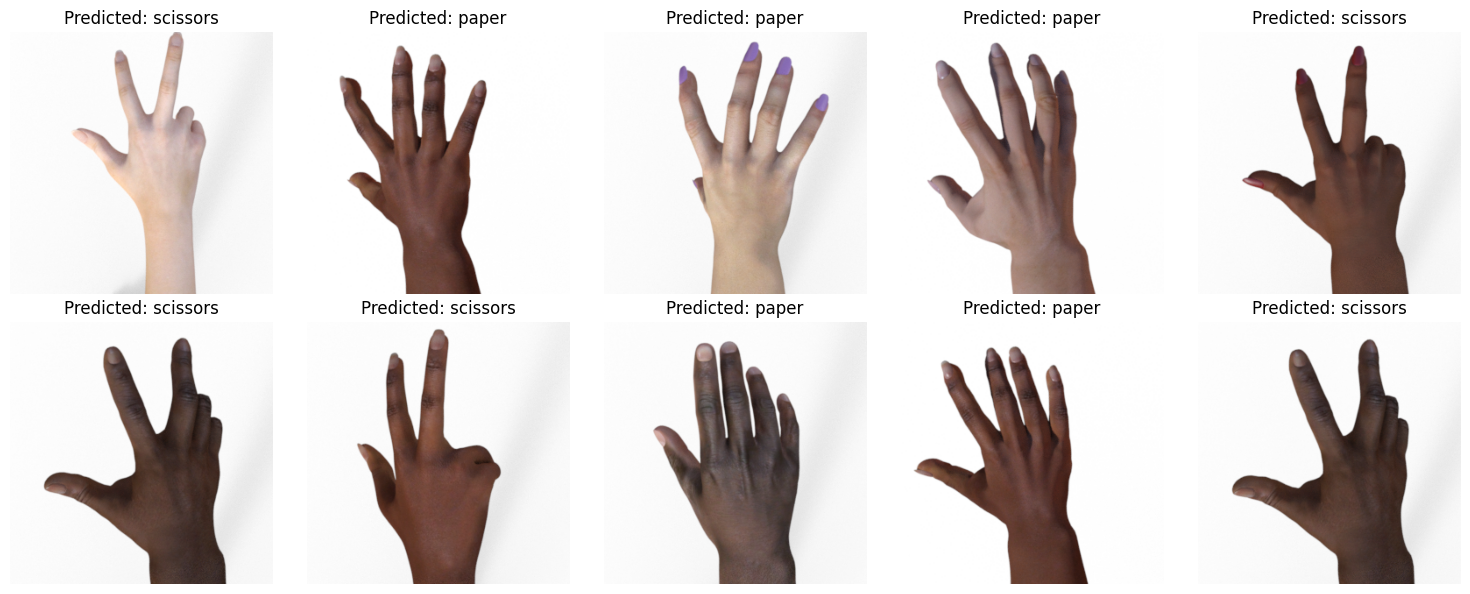

In [24]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
loaded_model = load_model('model_predictv4.h5')

# List all subdirectories in the test directory
subdirs = ['paper', 'rock', 'scissors']

# Initialize an empty list to store paths to all images
all_images = [os.path.join(test_dir, subdir, img) for subdir in subdirs for img in os.listdir(os.path.join(test_dir, subdir))]

# Shuffle the list of all images
random.shuffle(all_images)

# Display 10 random images with predictions
plt.figure(figsize=(15, 6))
for i, image_path in enumerate(all_images[:10]):
    # Read and process the image
    img_array = img_to_array(load_img(image_path, target_size=(150, 150))) / 255.0  # Normalize

    # Make a prediction using the loaded model
    prediction = loaded_model.predict(np.expand_dims(img_array, axis=0))

    # Display the image and prediction result
    predicted_label = subdirs[np.argmax(prediction)]

    plt.subplot(2, 5, i + 1)
    plt.imshow(load_img(image_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()